# Sea Ice Concentration in May Data Processing from CESM2-LE
- Process data for Southern Ocean SIC in May (for krill)
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- October 2024

## May SIC

- Krill need to be under ice cover (15%) by May 15 or the larvae will die over winter

In [1]:
import utils
import xarray as xr
import numpy as np
import dask
from distributed import Client
from ncar_jobqueue import NCARCluster
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs

/glade/work/duvivier/miniconda3/envs/analysis3/lib/python3.7/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


## Spin up DASK cluster

In [2]:
# Create our NCAR Cluster - which uses PBSCluster under the hood
cluster = NCARCluster(walltime='2:00:00', cores=1, processes=1, memory='100 GB', 
                      resource_spec='select=1:ncpus=1:mem=100GB',interface='ext')

# Spin up 32 workers
cluster.scale(32)

# Assign the cluster to our Client
client = Client(cluster)

In [3]:
client
# cluster.close()

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.58:43397,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/duvivier/PBS/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Define some functions we'll need to load data

In [4]:
# define the metrics we can load 
metrics_dict = {
    "SIC": ['aice'],
}

def get_metrics_list():
    return list(metrics_dict.keys())

In [5]:
# function to return the variables we need to return for all metrics
def get_metric_variable(metric):
    var_names = metrics_dict[metric]
    # handle the case where there is only one variable
    if isinstance(var_names, str):
        return var_names
    # handle the case where there are multiple variables
    else:
        return var_names[:]

In [6]:
# function to average over top 150m for relevant variables and to keep time bound
def preprocess(ds):
    tb = ds.time_bounds    
    #re-write time bound with saved value
    ds['time_bound'] = tb
    return ds

In [7]:
# function for loading datasets
def load_datasets(varnames, experiment,lat_min,lat_max):
    ds_list = []
    for varname in varnames:
        subset = catalog.search(component='ice',
                                variable=varname,
                                experiment=experiment,
                                forcing_variant='cmip6',
                               )
        with dask.config.set(**{'array.slicing.split_large_chunks': True}):
            dsets = subset.to_dataset_dict()
        ds = dsets[f'ice.{experiment}.cice.h.cmip6.{varname}'] 
        
        # compute time mean to get correct months
        ds['time']= ds.time_bounds.compute().mean(dim="d2")
        # keep only some variables
        keep_vars=['time_bounds','TLAT','TLON','tarea','time'] + [varname]
        ds = ds.drop([v for v in ds.variables if v not in keep_vars])
        ds_list.append(ds)
        ds = xr.merge(ds_list, compat="override")
        
        # crop data to the latitudes we want, use given lat/lon, not specific indices
        #ds = ds.isel(nlat=slice(0,37)) # Crop to Southern Ocean, ind_start = 0, ind_end = 37
        ds = ds.where(((ds['TLAT'] <= lat_max) & (ds['TLAT'] >= lat_min)), drop=True)
        
    return ds

## Select the metric you are interested in

In [8]:
import utils

In [9]:
## Print out potential metrics to investigate:
metrics_list = get_metrics_list()
print(metrics_list)

['SIC']


In [10]:
## Enter the metric  of interest:
metric = 'SIC'

In [11]:
## Enter the years you want to keep:
yy_st = "1950"
yy_ed = "2100"

In [12]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

## Load CESM2-LE data

In [13]:
# for the metric supplied, define the list of required variable names
varnames = get_metric_variable(metric) 
varnames

['aice']

### Load the Data Catalog

In [14]:
catalog = intake.open_esm_datastore(
    '/glade/collections/cmip/catalog/intake-esm-datastore/catalogs/glade-cesm2-le.json'
)

### Load historical data

In [15]:
%%time
# load historical
ds_hist = load_datasets(varnames,'historical',lat_min,lat_max)
ds_hist


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 19.2 s, sys: 691 ms, total: 19.9 s
Wall time: 34.9 s


<xarray.Dataset>
Dimensions:      (nj: 36, ni: 320, time: 1980, d2: 2, member_id: 50)
Coordinates:
    TLON         (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT         (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
  * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
Dimensions without coordinates: nj, ni, d2, member_id
Data variables:
    tarea        (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    time_bounds  (time, d2, nj, ni) object dask.array<chunksize=(120, 2, 36, 320), meta=np.ndarray>
    aice         (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 120, 36, 320), meta=np.ndarray>
Attributes:
    contents:                Diagnostic and Prognostic Variables
    comment3:                seconds elapsed into model date:      0
    intake_esm_varname:      ['aice']
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    conventions:             CF-1.0
    comment:                 All years have exactly 365 days
    comment2:                File written on model date 20100201
    io_flavor:               io_pio
    time_period_freq:        month_1
    history:                 This dataset was created on 2020-02-01 at 05:49\...
    intake_esm_dataset_key:  ice.historical.cice.h.cmip6.aice

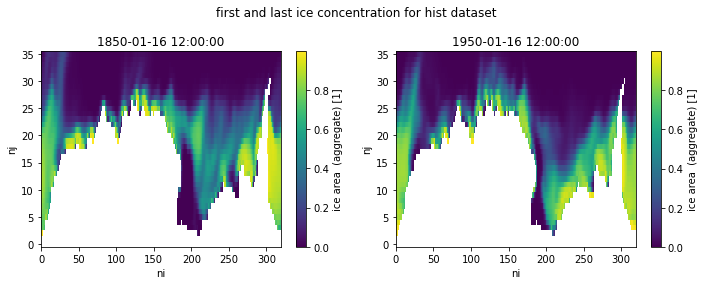

In [16]:
# check that this data looks reasonable

mem_5_hist = ds_hist.aice.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_hist.isel(time=0).plot(ax=ax1)
ax1.set_title(mem_5_hist.isel(time=0).time.values)

mem_5_hist.isel(time=1200).plot(ax=ax2)
ax2.set_title(mem_5_hist.isel(time=1200).time.values)

fig.suptitle("first and last ice concentration for hist dataset")

plt.tight_layout()
plt.show()

### Load future data

In [17]:
%%time
# load future
ds_ssp = load_datasets(varnames, 'ssp370',lat_min,lat_max)
ds_ssp


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.stream.forcing_variant.variable'


CPU times: user 8.35 s, sys: 104 ms, total: 8.46 s
Wall time: 9.79 s


<xarray.Dataset>
Dimensions:      (nj: 36, ni: 320, time: 1032, d2: 2, member_id: 50)
Coordinates:
    TLON         (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    TLAT         (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
  * time         (time) object 2015-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: nj, ni, d2, member_id
Data variables:
    tarea        (nj, ni) float32 dask.array<chunksize=(36, 320), meta=np.ndarray>
    time_bounds  (time, d2, nj, ni) object dask.array<chunksize=(120, 2, 36, 320), meta=np.ndarray>
    aice         (member_id, time, nj, ni) float32 dask.array<chunksize=(1, 120, 36, 320), meta=np.ndarray>
Attributes:
    contents:                Diagnostic and Prognostic Variables
    comment3:                seconds elapsed into model date:      0
    intake_esm_varname:      ['aice']
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    conventions:             CF-1.0
    comment:                 All years have exactly 365 days
    comment2:                File written on model date 20950201
    io_flavor:               io_pio
    time_period_freq:        month_1
    history:                 This dataset was created on 2020-04-29 at 18:54\...
    intake_esm_dataset_key:  ice.ssp370.cice.h.cmip6.aice

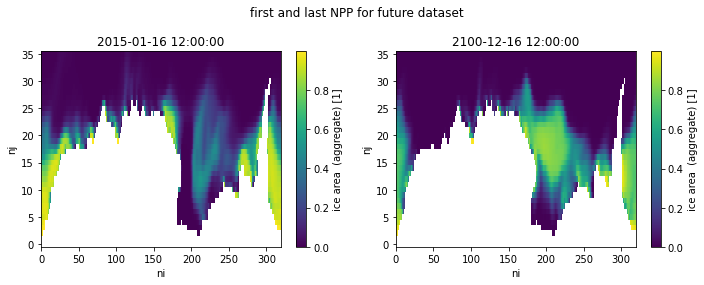

In [18]:
# check that this data looks reasonable

mem_5_ssp = ds_ssp.aice.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_ssp.isel(time=0).plot(ax=ax1)
ax1.set_title(mem_5_ssp.isel(time=0).time.values)

mem_5_ssp.isel(time=-1).plot(ax=ax2)
ax2.set_title(mem_5_ssp.isel(time=-1).time.values)

fig.suptitle("first and last NPP for future dataset")

plt.tight_layout()
plt.show()

## Concatenate historical and future datasets and crop to just the times we need


In [19]:
ds = xr.concat((ds_hist, ds_ssp),dim='time')
ds.time

<xarray.DataArray 'time' (time: 3012)>
array([cftime.DatetimeNoLeap(1850, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00

In [20]:
#rename dimensions
ds = ds.rename({'nj':'nlat','ni': 'nlon'})

In [21]:
ds

<xarray.Dataset>
Dimensions:      (time: 3012, nlat: 36, nlon: 320, d2: 2, member_id: 50)
Coordinates:
    TLON         (nlat, nlon) float32 320.6 321.7 322.8 ... 317.2 318.3 319.4
    TLAT         (nlat, nlon) float32 -79.22 -79.22 -79.22 ... -60.52 -60.52
  * time         (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: nlat, nlon, d2, member_id
Data variables:
    tarea        (time, nlat, nlon) float32 dask.array<chunksize=(1980, 36, 320), meta=np.ndarray>
    time_bounds  (time, d2, nlat, nlon) object dask.array<chunksize=(120, 2, 36, 320), meta=np.ndarray>
    aice         (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 120, 36, 320), meta=np.ndarray>
Attributes:
    contents:                Diagnostic and Prognostic Variables
    comment3:                seconds elapsed into model date:      0
    intake_esm_varname:      ['aice']
    model_doi_url:           https://doi.org/10.5065/D67H1H0V
    source:                  Los Alamos Sea Ice Model (CICE) Version 5
    conventions:             CF-1.0
    comment:                 All years have exactly 365 days
    comment2:                File written on model date 20100201
    io_flavor:               io_pio
    time_period_freq:        month_1
    history:                 This dataset was created on 2020-02-01 at 05:49\...
    intake_esm_dataset_key:  ice.historical.cice.h.cmip6.aice

In [22]:
# keep just years chosen above
ds = ds.sel(time=slice(yy_st, yy_ed))
#ds = ds.isel(time=slice(1200, 3012)) # Cut timeseries to 1950 - 2100: 1812 time steps
ds.time

<xarray.DataArray 'time' (time: 1812)>
array([cftime.DatetimeNoLeap(1950, 1, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1950, 2, 15, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1950, 3, 16, 12, 0, 0, 0, has_year_zero=True),
       ...,
       cftime.DatetimeNoLeap(2100, 10, 16, 12, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 11, 16, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(2100, 12, 16, 12, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1950-01-16 12:00:00 ... 2100-12-16 12:00:00

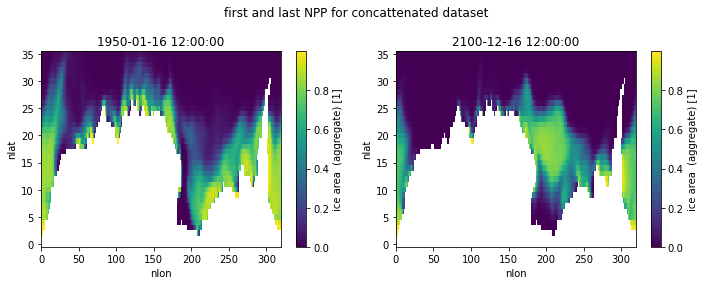

In [23]:
# check that this data looks reasonable

mem_5 = ds.aice.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5.isel(time=0).plot(ax=ax1)
ax1.set_title(mem_5.isel(time=0).time.values)

mem_5.isel(time=-1).plot(ax=ax2)
ax2.set_title(mem_5.isel(time=-1).time.values)

fig.suptitle("first and last NPP for concattenated dataset")

plt.tight_layout()
plt.show()

# Get May SIC

In [26]:
data = ds['aice']

In [27]:
# Keep May only
data_keep = data.where(data.time.dt.month == 5, drop=True)

## Put together into one dataset

- Netcdf with variable dimension: (member_id x year x nlat x nlon) Include TLAT and TLONG as coordinates

In [28]:
# load grid data to include in output file
dir_in = '/glade/u/home/duvivier/masks/'
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon

# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

In [31]:
ds_out = xr.Dataset()

ds_out['SIC_MAY'] = data_keep

# change the attributes
ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'May sea ice fraction in the Southern Ocean from 1950 to 2099.'

ds_out

,Array,Chunk
Bytes,331.79 MiB,450.00 kiB
Shape,"(50, 151, 36, 320)","(1, 10, 36, 320)"
Count,12847 Tasks,800 Chunks
Type,float32,numpy.ndarray


In [32]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")
    

Dimensions:
	nlat: (36,)
	nlon: (320,)
	time: (151,)
	member_id: (50,)
Coordinates:
	TLON:
		[[320.5625 321.6875 322.8125 ... 317.1875 318.3125 319.4375]
 [320.5625 321.6875 322.8125 ... 317.1875 318.3125 319.4375]
 [320.5625 321.6875 322.8125 ... 317.1875 318.3125 319.4375]
 ...
 [320.5625 321.6875 322.8125 ... 317.1875 318.3125 319.4375]
 [320.5625 321.6875 322.8125 ... 317.1875 318.3125 319.4375]
 [320.5625 321.6875 322.8125 ... 317.1875 318.3125 319.4375]]
	TLAT:
		[[-79.22052  -79.22052  -79.22052  ... -79.22052  -79.22052  -79.22052 ]
 [-78.68631  -78.68631  -78.68631  ... -78.68631  -78.68631  -78.68631 ]
 [-78.15209  -78.15209  -78.15209  ... -78.15209  -78.15209  -78.15209 ]
 ...
 [-61.59125  -61.59125  -61.59125  ... -61.59125  -61.59125  -61.59125 ]
 [-61.057022 -61.057022 -61.057022 ... -61.057022 -61.057022 -61.057022]
 [-60.522797 -60.522797 -60.522797 ... -60.522797 -60.522797 -60.522797]]
	time:
		[cftime.DatetimeNoLeap(1950, 5, 16, 12, 0, 0, 0, has_year_zero=True)
 cft

## Export and Save

In [33]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")


The dataset is approximately 0.32 GB.


In [34]:
path_out = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/sea_ice/'
file_out = 'CESM2-LE-SIC_MAY.nc'
fout = path_out + file_out

In [35]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)

In [36]:
cluster.close()

## Test if it worked

In [37]:
import netCDF4
nc = netCDF4.Dataset(fout)
print(nc.variables)

{'TLON': <class 'netCDF4._netCDF4.Variable'>
float32 TLON(nlat, nlon)
    _FillValue: 1e+30
    long_name: T grid center longitude
    units: degrees_east
    bounds: lont_bounds
    missing_value: 1e+30
unlimited dimensions: 
current shape = (36, 320)
filling on, 'TLAT': <class 'netCDF4._netCDF4.Variable'>
float32 TLAT(nlat, nlon)
    _FillValue: 1e+30
    long_name: T grid center latitude
    units: degrees_north
    bounds: latt_bounds
    missing_value: 1e+30
unlimited dimensions: 
current shape = (36, 320)
filling on, 'time': <class 'netCDF4._netCDF4.Variable'>
int64 time(time)
    units: days since 1950-05-16 12:00:00.000000
    calendar: noleap
unlimited dimensions: 
current shape = (151,)
filling on, default _FillValue of -9223372036854775806 used, 'SIC_MAY': <class 'netCDF4._netCDF4.Variable'>
float32 SIC_MAY(member_id, time, nlat, nlon)
    _FillValue: nan
    units: 1
    long_name: ice area  (aggregate)
    cell_measures: area: tarea
    cell_methods: time: mean
    time_re

In [38]:
path =  path_out
ds_in =  xr.open_dataset(path_out+file_out, decode_times=True)

In [39]:
ds_in.info()

xarray.Dataset {
dimensions:
	nlat = 36 ;
	nlon = 320 ;
	time = 151 ;
	member_id = 50 ;

variables:
	float32 TLON(nlat, nlon) ;
		TLON:long_name = T grid center longitude ;
		TLON:units = degrees_east ;
		TLON:bounds = lont_bounds ;
	float32 TLAT(nlat, nlon) ;
		TLAT:long_name = T grid center latitude ;
		TLAT:units = degrees_north ;
		TLAT:bounds = latt_bounds ;
	object time(time) ;
	float32 SIC_MAY(member_id, time, nlat, nlon) ;
		SIC_MAY:units = 1 ;
		SIC_MAY:long_name = ice area  (aggregate) ;
		SIC_MAY:cell_measures = area: tarea ;
		SIC_MAY:cell_methods = time: mean ;
		SIC_MAY:time_rep = averaged ;

// global attributes:
	:author = Alice DuVivier ;
	:date_processed = 2024-10-28 ;
	:contents = May sea ice fraction in the Southern Ocean from 1950 to 2099. ;
}

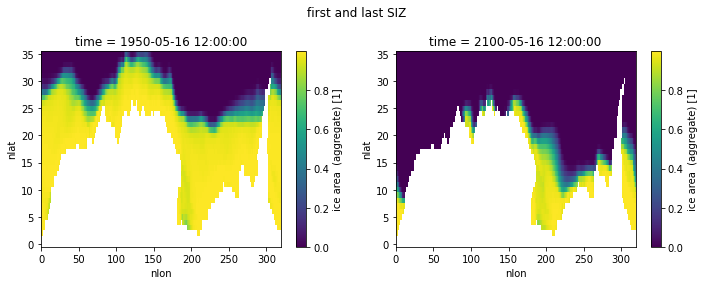

In [40]:
mem_5_ints = ds_in.SIC_MAY.isel(member_id=5)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))

mem_5_ints.isel(time=0).plot(ax=ax1)

mem_5_ints.isel(time=-1).plot(ax=ax2)

fig.suptitle("first and last SIZ")

plt.tight_layout()
plt.show()